<a href="https://colab.research.google.com/github/YeonJun-IN/coursera-how_to_win_ds_competition/blob/master/EDA_Springleaf_wk2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import pandas as pd 
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import seaborn

In [0]:
def autolabel(arrayA):
    ''' label each colored square with the corresponding data value. 
    If value > 20, the text is in black, else in white.
    '''
    arrayA = np.array(arrayA)
    for i in range(arrayA.shape[0]):
        for j in range(arrayA.shape[1]):
                plt.text(j,i, "%.2f"%arrayA[i,j], ha='center', va='bottom',color='w')

def hist_it(feat):
    plt.figure(figsize=(16,4))
    feat[Y==0].hist(bins=range(int(feat.min()),int(feat.max()+2)),normed=True,alpha=0.8)
    feat[Y==1].hist(bins=range(int(feat.min()),int(feat.max()+2)),normed=True,alpha=0.5)
    plt.ylim((0,1))
    
def gt_matrix(feats,sz=16):
    a = []
    for i,c1 in enumerate(feats):
        b = [] 
        for j,c2 in enumerate(feats):
            mask = (~train[c1].isnull()) & (~train[c2].isnull())
            if i>=j:
                b.append((train.loc[mask,c1].values>=train.loc[mask,c2].values).mean())
            else:
                b.append((train.loc[mask,c1].values>train.loc[mask,c2].values).mean())

        a.append(b)

    plt.figure(figsize = (sz,sz))
    plt.imshow(a, interpolation = 'None')
    _ = plt.xticks(range(len(feats)),feats,rotation = 90)
    _ = plt.yticks(range(len(feats)),feats,rotation = 0)
    autolabel(a)

In [0]:
def hist_it1(feat):
    plt.figure(figsize=(16,4))
    feat[Y==0].hist(bins=100,range=(feat.min(),feat.max()),normed=True,alpha=0.5)
    feat[Y==1].hist(bins=100,range=(feat.min(),feat.max()),normed=True,alpha=0.5)
    plt.ylim((0,1))

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
os.chdir('/content/drive/My Drive/연준/DS/coursera/wk2_EDA/data')

# Read the data

In [0]:
train = pd.read_csv('train.csv.zip')
Y = train.target

In [0]:
test = pd.read_csv('test.csv.zip')
test_ID = test.ID

# Data overview
가장 먼저 체크해야할 것은 train과 test의 shape.

In [8]:
print('Train shape', train.shape)
print('Test shape', test.shape)

Train shape (145231, 1934)
Test shape (145232, 1933)


In [9]:
train.head()

,ID,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0008,VAR_0009,VAR_0010,VAR_0011,VAR_0012,VAR_0013,VAR_0014,VAR_0015,VAR_0016,VAR_0017,VAR_0018,VAR_0019,VAR_0020,VAR_0021,VAR_0022,VAR_0023,VAR_0024,VAR_0025,VAR_0026,VAR_0027,VAR_0028,VAR_0029,VAR_0030,VAR_0031,VAR_0032,VAR_0033,VAR_0034,VAR_0035,VAR_0036,VAR_0037,VAR_0038,VAR_0039,...,VAR_1896,VAR_1897,VAR_1898,VAR_1899,VAR_1900,VAR_1901,VAR_1902,VAR_1903,VAR_1904,VAR_1905,VAR_1906,VAR_1907,VAR_1908,VAR_1909,VAR_1910,VAR_1911,VAR_1912,VAR_1913,VAR_1914,VAR_1915,VAR_1916,VAR_1917,VAR_1918,VAR_1919,VAR_1920,VAR_1921,VAR_1922,VAR_1923,VAR_1924,VAR_1925,VAR_1926,VAR_1927,VAR_1928,VAR_1929,VAR_1930,VAR_1931,VAR_1932,VAR_1933,VAR_1934,target
0,2,H,224,0,4300,C,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,997,997,997,147,198,173,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,IAPS,0
1,4,H,7,53,4448,B,1.0,0.0,False,False,False,False,False,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,49,49,3,21,12,2,2,0,2,0,0,0,0,0,6546,6546,6125,76,1,1,9996,111,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,IAPS,0
2,5,H,116,3,3464,C,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,997,997,45,46,46,1,0,0,3,0,97,0,97,997,999999997,999999997,999999997,999999997,1,997,9996,113,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,IAPS,0
3,7,H,240,300,3200,C,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,120,30,996,996,15,188,106,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,RCC,0
4,8,R,72,261,2000,N,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,30,1,17,17,76,443,230,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,BRANCH,1


In [10]:
test.head()

,ID,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0008,VAR_0009,VAR_0010,VAR_0011,VAR_0012,VAR_0013,VAR_0014,VAR_0015,VAR_0016,VAR_0017,VAR_0018,VAR_0019,VAR_0020,VAR_0021,VAR_0022,VAR_0023,VAR_0024,VAR_0025,VAR_0026,VAR_0027,VAR_0028,VAR_0029,VAR_0030,VAR_0031,VAR_0032,VAR_0033,VAR_0034,VAR_0035,VAR_0036,VAR_0037,VAR_0038,VAR_0039,...,VAR_1895,VAR_1896,VAR_1897,VAR_1898,VAR_1899,VAR_1900,VAR_1901,VAR_1902,VAR_1903,VAR_1904,VAR_1905,VAR_1906,VAR_1907,VAR_1908,VAR_1909,VAR_1910,VAR_1911,VAR_1912,VAR_1913,VAR_1914,VAR_1915,VAR_1916,VAR_1917,VAR_1918,VAR_1919,VAR_1920,VAR_1921,VAR_1922,VAR_1923,VAR_1924,VAR_1925,VAR_1926,VAR_1927,VAR_1928,VAR_1929,VAR_1930,VAR_1931,VAR_1932,VAR_1933,VAR_1934
0,1,R,360,25,2251,B,2.0,2.0,False,False,False,False,False,2.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,25,1,1,92,92,8,133,71,3,1,0,4,3,0,1,0,0,6121,49188,6121,70,400,1,47,56,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,IAPS
1,3,R,74,192,3274,C,2.0,3.0,False,False,False,False,False,2.0,3.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,...,91,1,1,75,75,45,181,136,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,IAPS
2,6,R,21,36,3500,C,1.0,1.0,False,False,False,False,False,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,999999997,400,400,997,997,80,138,108,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,IAPS
3,9,R,8,2,1500,B,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,999999997,1,997,997,997,48,48,48,0,0,0,2,0,0,0,0,0,999999996,21362,999999996,999999996,1,1,9996,6,2,1,1140,41300,381,0,98,98,998,999999998,998,998,9998,9998,IAPS
4,10,H,91,39,84500,C,8.0,3.0,False,False,False,False,False,8.0,3.0,1.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,...,45,1,1,53,20,23,50,35,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,IAPS


2000개의 익명 변수들. 앞쪽에 쓱 보니까 categorical도 있고, numeric도 있고. numeric 중에는 integer도 있고(event counter 같은거), float도 있다.

다 integer인데 na가 있으면 float이 된다네?

ID 컬럼을 보면 train이랑 test를 붙여놓고 있다가 random으로 반반 샘플링한 것을 알 수 잇음. 

NA가 있는 지 확인하는 것도 중요함. 
na가 있는 column에 집중해야하고, row당 na개수가 좋은 변수로 작용하기도 함

In [11]:
train.isnull().sum(axis=1).head(15)

0     25
1     19
2     24
3     24
4     24
5     24
6     24
7     24
8     16
9     24
10    22
11    24
12    17
13    24
14    24
dtype: int64

24인 애들이 연속적으로 나타난다.

=> 행 순서가 어떤 의미를 담고 있다. 즉, sampling은 랜덤으로 되었어도, row의 순서는 변하지 않았다

=> row index를 feature로 사용할 수 있다(이건 좀 안와닿네)

In [12]:
train.isnull().sum(axis=0).head(15)

ID           0
VAR_0001     0
VAR_0002     0
VAR_0003     0
VAR_0004     0
VAR_0005     0
VAR_0006    56
VAR_0007    56
VAR_0008    56
VAR_0009    56
VAR_0010    56
VAR_0011    56
VAR_0012    56
VAR_0013    56
VAR_0014    56
dtype: int64

row와 마찬가지로 column도 같은 개수의 na가 연속적으로 나오는게 어떤 의미를 담고 있고, 우연이 아니다. 

=> column도 order가 random이 아니다

대충 15개쯤 보니까 

NA가 56개인 columns

NA가 24개인 row가 많음

요것이 패턴


# Dataset cleaning

## remove constant features

1932개의 column들은 우리가 feature들의 의미를 알아채지 못하게 익명화 되어있음. 
저번 수업때 말했듯이 일단 제일 먼저 해야한 것은 feature type 정하는 거임

그래서 이제 dataset을 clean해볼거임

train이랑 test를 concat하고 하는게 편함!





In [0]:
traintest = pd.concat([train,test],axis= 0)

먼저 constant feature를 찾아보자. 그런 feature들은 정보도 주지 못하고, 데이터만 크게 만든다

In [0]:
feats_counts = train.nunique(dropna=False)

In [15]:
feats_counts.sort_values()[:10]

VAR_0213    1
VAR_0207    1
VAR_0840    1
VAR_0847    1
VAR_1428    1
VAR_1165    2
VAR_0438    2
VAR_1164    2
VAR_1163    2
VAR_1162    2
dtype: int64

보니까 5개가 constant feature네. 삭제하자

In [16]:
constant_features = feats_counts[feats_counts == 1].index.tolist()
print(constant_features)

traintest.drop(constant_features, axis=1,inplace=True)

['VAR_0207', 'VAR_0213', 'VAR_0840', 'VAR_0847', 'VAR_1428']


### remove duplicated features

na을 나중에 우리가 알아볼 수 있는 값으로 바꿔준다

그리고 저번 수업 때 얘기 햇듯이, label encoding을 해야 duplicate 변수를 알 수 있으니까 

임시 테이블을 만들어서 label encoding을 해보자

In [0]:
#traintest.fillna('NaN',inplace = True)

In [21]:
train_enc = pd.DataFrame(index = train.index)

for col in tqdm_notebook(traintest.columns):
  train_enc[col] = train[col].factorize()[0]

이러케도 할 수 있음. 

train_enc[col] = train[col].map(train[col].value_counts())

In [22]:
dup_cols = {}

for i, c1 in enumerate(tqdm_notebook(train_enc.columns)):
  for c2 in train_enc.columns[i+1:]:
    if c2 not in dup_cols and np.all(train_enc[c1] == train_enc[c2]):
      dup_cols[c2] = c1

In [0]:
dup_cols

In [0]:
pd.DataFrame({'v1' : list(dup_cols.keys()),
             'v2': list(dup_cols.values())}).to_pickle('dup_cols.pkl')

In [0]:
traintest.drop(dup_cols.keys(), axis = 1, inplace = True)

# Determin types
unique value 개수를 봐보자

In [36]:
nunique = train.nunique(dropna=False)
nunique

ID          145231
VAR_0001         3
VAR_0002       820
VAR_0003       588
VAR_0004      7935
             ...  
VAR_1931        10
VAR_1932        74
VAR_1933       363
VAR_1934         5
target           2
Length: 1934, dtype: int64

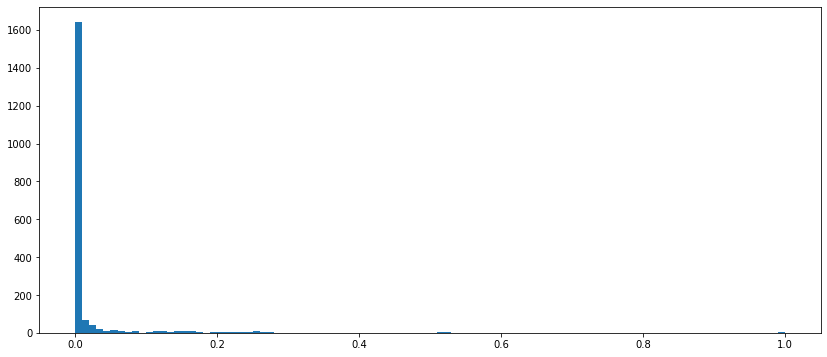

In [37]:
plt.figure(figsize = (14,6))
_ = plt.hist(nunique.astype(float)/train.shape[0], bins = 100)

unique value의 개수가 많은 feature들을 살펴보자

In [40]:
mask = nunique.astype(float)/train.shape[0] > 0.8
train.loc[:,mask]

,ID,VAR_0212,VAR_0227,VAR_0228
0,2,NaN,311951.0,311951.0
1,4,9.207125e+10,2769488.0,2769488.0
2,5,2.654775e+10,654127.0,654127.0
3,7,7.757535e+10,3015088.0,3015088.0
4,8,6.042377e+10,118678.0,118678.0
...,...,...,...,...
145226,290457,7.050881e+10,2036570.0,2036570.0
145227,290458,9.024919e+10,1680132.0,1680132.0
145228,290459,9.172239e+10,2419219.0,2419219.0
145229,290461,4.510331e+10,1539605.0,1539605.0


값을 보면 float이 아니고 integer임. 이 featur들은 count 값이라고 볼 수 있음.

예를 들면 시간. millisecond, nanosecond 등등 이런거. cdt 같은거. uptdt_ 같은거. 

다른 경우도 보자

In [44]:
mask = (nunique.astype(float)/train.shape[0] < 0.8) & (nunique.astype(float)/train.shape[0] > 0.4)
train.loc[:25,mask]

,VAR_0541,VAR_0543,VAR_0899,VAR_1081,VAR_1082,VAR_1087,VAR_1179,VAR_1180,VAR_1181
0,49463,116783,112871,76857,76857,116783,76857,76857,76857
1,303472,346196,346375,341365,341365,346196,341365,341365,176604
2,94990,122601,121501,107267,107267,121501,107267,107267,58714
3,20593,59490,61890,45794,47568,59490,45794,47568,47568
4,10071,35708,34787,20475,23647,34708,20475,23647,23647
5,18877,28055,28455,21139,21139,28055,21139,21139,20627
6,321783,333565,886886,327744,327744,333565,327744,327744,163944
7,2961,5181,11084,4326,4326,5181,4326,4326,4326
8,20359,30114,33434,24969,27128,30114,24969,27128,27128
9,815,1300,7677,1197,1197,1300,1197,1197,1197


모두 integer인거로 봐서는 count인건 같다. 

1. 23번째 줄을 보면 값이 9999999, -9999 막 이렇다. NA를 채운것으로 생각할 수 있다. 
2. 그리고 column 이름을 보면 연속적인 혹은 비슷한 순번이 있다. 얘네들은 아마 group일 수 있다. 나중에 group을 구별해봐도 좋을듯 하다.
3. 첫줄을 보면 같은 값들이 있는 걸 알 수 있음. 다른 줄도 보면 그런것도 있고 아닌 것도 있는데. 이걸 가지고 feature를 만들 수도 있는 거임. 한 줄에 같은 값이 있는 col이 몇개인지 같은거.

**결론 : float 변수는 없고, count에 대한 변수가 몇개 있다. numeric으로 취급할 것이다**

그룹1 : 0.8 ~

그룹2 : 0.4 ~ 0.8

그룹3 : ~ 0.4 > 여기서 아무거나 하나 뽑아서 봐보자. VAR_0015

In [46]:
train['VAR_0015'].value_counts(dropna = False)

0.0     102382
1.0      28045
2.0       8981
3.0       3199
4.0       1274
5.0        588
6.0        275
7.0        166
8.0         97
NaN         56
9.0         51
10.0        39
11.0        18
12.0        16
13.0         9
14.0         8
15.0         8
16.0         6
22.0         3
21.0         3
19.0         1
35.0         1
17.0         1
29.0         1
18.0         1
32.0         1
23.0         1
Name: VAR_0015, dtype: int64

다 양수 값인걸 보니 counter 인듯. event가 몇번이나 일어났는지

In [0]:
cat_cols = list(train.select_dtypes(include = ['object']).columns)
num_cols = list(train.select_dtypes(exclude = ['object']).columns)

# Go through
한 변수가 다른 변수보다 더 큰 값이 몇개나 있는지 cross table로 만들어보자

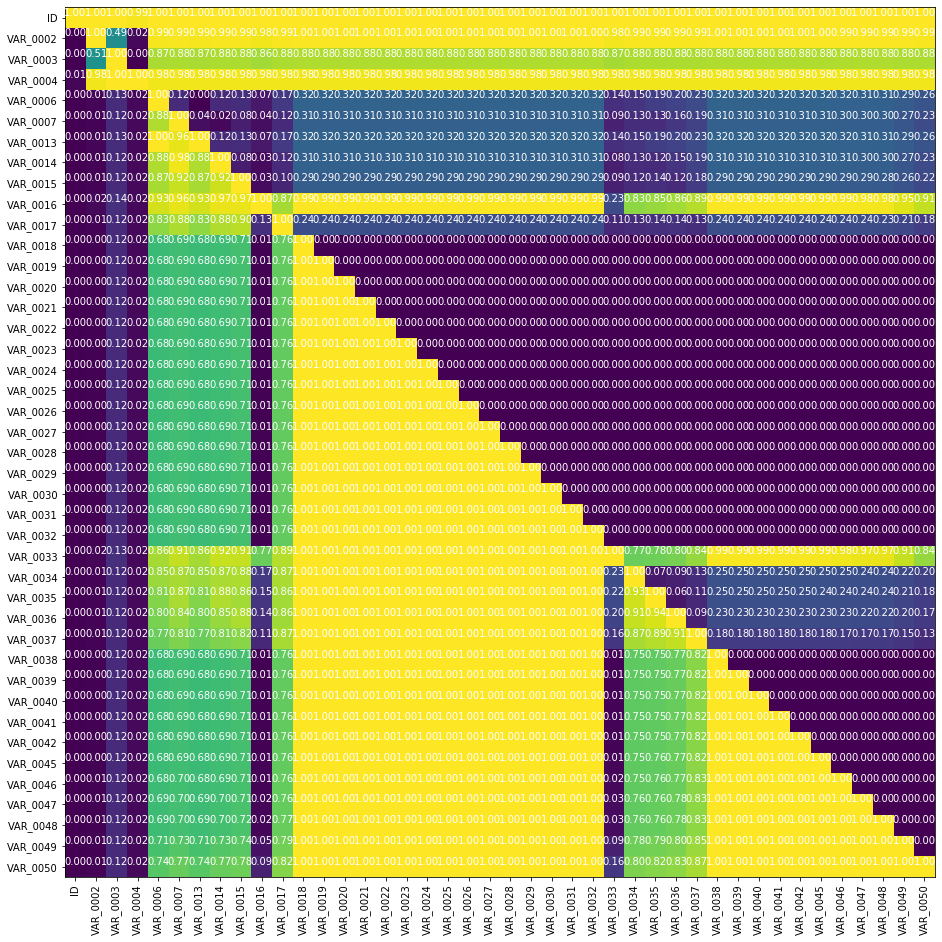

In [50]:
feats = num_cols[:42]

gt_matrix(feats,16)

여기서 재밌는 패턴을 볼 수 있다. 

한 변수가 다른 변수보다 무조건 값이 큰 block이 있다. 가설을 세워보기를, 하나가 하나의 누적값이 아닐까? 

예를 들면 하나는 첫 달의 count, 하나는 1,2달의 count 같은.

그래서 즉시 이해하기를, 

**연속된 값의 차이 값으로 feature를 만드는 것이 tree-based model에 더 효과적일 것이다.**

* linear모델은 그걸 알아서 하는데 트리는 못함*
*연속된 값의 차이 => 예를 들면 각 월의 event count*


# VAR_0002, VAR_0003

(-10, 1010)

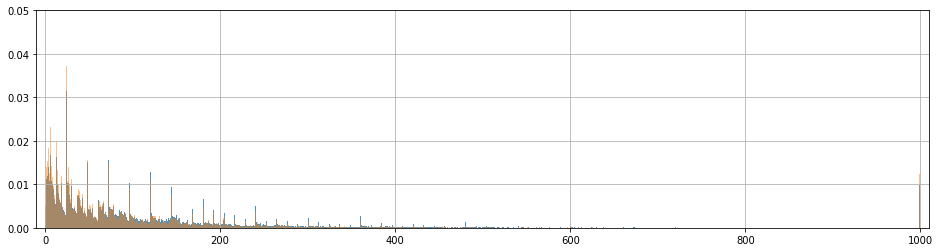

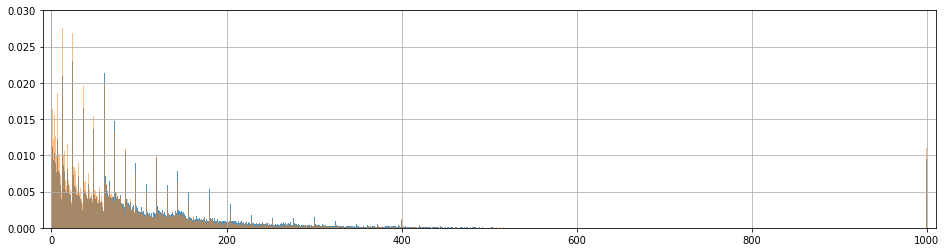

In [51]:
hist_it(train['VAR_0002'])
plt.ylim((0,0.05))
plt.xlim((-10,1010))

hist_it(train['VAR_0003'])
plt.ylim((0,0.03))
plt.xlim((-10,1010))

히스토그램을 보면 저 peak들이 신경쓰인다.


In [53]:
train['VAR_0002'].value_counts()

12     5264
24     4763
36     3499
60     2899
6      2657
       ... 
675       1
674       1
745       1
778       1
851       1
Name: VAR_0002, Length: 820, dtype: int64

In [54]:
train['VAR_0003'].value_counts()

0      17436
24      3469
12      3271
60      3054
36      2498
       ...  
523        1
584        1
759        1
583        1
570        1
Name: VAR_0003, Length: 588, dtype: int64

12,24,36,60 등등의 값 확인.

어쩌면 시간에 관련된 것일지도?? 

feature로 12로 나눈다음의 나머지 값을 넣을 수도 있고 몫을 넣을 수도 잇고. 
VAR_0002, VAR_0003 둘다 마찬가지

# VAR_0004

(0, 0.6)

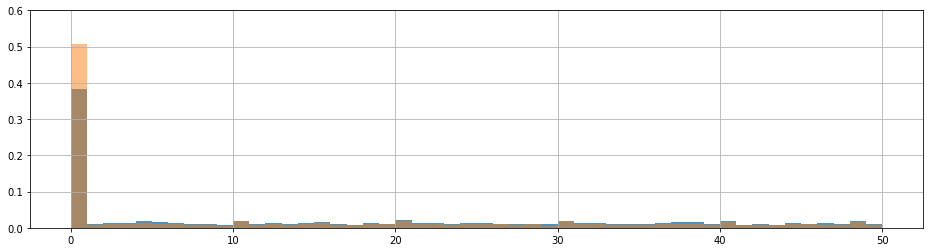

In [58]:
train['VAR_0004_mod50'] = train['VAR_0004'] % 50
hist_it(train['VAR_0004_mod50'])
plt.ylim((0,0.6))

보면 0 보다 큰 값들은 분포가 거의 동일, 0에서는 분포가 꽤 다름. 

즉 0 값일 때는 꽤나 discriminative 한 변수라는 것을 알 수 있음.

# Categorical features

In [60]:
train.loc[:,cat_cols].head().T

,0,1,2,3,4
VAR_0001,H,H,H,H,R
VAR_0005,C,B,C,C,N
VAR_0008,False,False,False,False,False
VAR_0009,False,False,False,False,False
VAR_0010,False,False,False,False,False
VAR_0011,False,False,False,False,False
VAR_0012,False,False,False,False,False
VAR_0043,False,False,False,False,False
VAR_0044,[],[],[],[],[]
VAR_0073,NaN,04SEP12:00:00:00,NaN,NaN,NaN


VAR_0200, VAR_0237, VAR_0274 는 뭔가 geographical 데이터 같아보임. 그래서 geography related feautre를 만들어야함.

알아보기 어려운 변수들이 많다. 하지만 보면, date columns인 VAR_0073, 0179, 0204, 0217이 있음. 

한 date를 다른 date와 같이 plot하면 어떤 관계를 찾기 유용함

In [0]:
date_cols = [u'VAR_0073','VAR_0075',
             u'VAR_0156',u'VAR_0157',u'VAR_0158','VAR_0159',
             u'VAR_0166', u'VAR_0167',u'VAR_0168',u'VAR_0169',
             u'VAR_0176',u'VAR_0177',u'VAR_0178',u'VAR_0179',
             u'VAR_0204',
             u'VAR_0217']

for c in date_cols:
    train[c] = pd.to_datetime(train[c],format = '%d%b%y:%H:%M:%S')
    test[c] = pd.to_datetime(test[c],  format = '%d%b%y:%H:%M:%S')

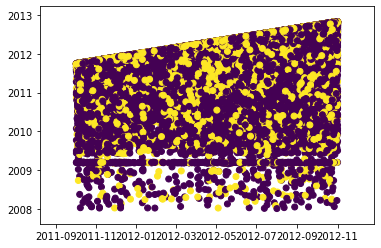

In [65]:
c1 = 'VAR_0217'
c2 = 'VAR_0073'

mask = (~train[c1].isnull()) & (~train[c2].isnull())
plt.scatter(train.loc[mask,c1].values, train.loc[mask,c2].values, c= train.loc[mask,'target'].values)

위 그래프가 의미하는 것은 한쪽이 한쪽보다 무조건 값이 크다는 것.

**두 date의 차이를 feature로 만들 수도 있는 것.**

